In [153]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import torch.nn.functional as F


In [154]:
class ECGDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values.astype(np.int64), dtype=torch.long).squeeze()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]




In [155]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(187, 256)
        
        self.linear2 = nn.Linear(256, 128)
        
        self.linear3 = nn.Linear(128, 64)
        self.norm3 = nn.LayerNorm(128)
        
        self.linear4 = nn.Linear(64, 32)
        self.norm4 = nn.LayerNorm(64)
        
        self.linear5 = nn.Linear(32, 16)
        self.norm5 = nn.LayerNorm(32)
        
        self.linear6 = nn.Linear(16, 5)

        self.avg1 = torch.nn.AvgPool1d(2, stride=2)
        self.avg2 = torch.nn.AvgPool1d(2, stride=2)
        self.avg3 = torch.nn.AvgPool1d(2, stride=2)


    def forward(self, x):
        
        x1 = F.relu(self.linear1(x))
        #print("x", x.shape)
#         print("x1", x1.shape)
        x1a=self.avg1(x1)
        x2 = F.relu(self.linear2(x1)) + x1a  # Add residual connection
#         print("x2", x2.shape)
        
        x2a=self.avg2(x2)
#         print("x2a", x2a.shape)
        x3 = F.relu(self.linear3( self.norm3(x2))) + x2a # residual 
#         print("x3", x3.shape)
        
        # avg 2 times to convert 64 to 16
        x3a = self.avg3(x3)
#         print("x3a", x3a.shape)
        
        
        x4 = F.relu(self.linear4( self.norm4(x3))) + x3a
#         print("x4", x4.shape)
        
        
        x5 = F.relu(self.linear5(self.norm5(x4)))
#         print("x5", x5.shape)
       
        z = self.linear6(x5)
#         print(z.shape)
        return z


In [157]:
model=Net()
x=torch.rand(1,187)
z=model(x)

In [35]:
..dataX = pd.read_csv('ECG_dataX.csv', header=None, skiprows=1)
dataY = pd.read_csv('ECG_dataY.csv', header=None, skiprows=1)

X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


In [36]:
batch_size = 64

dataset_train = ECGDataset(X_train, y_train)
dataset_val = ECGDataset(X_val, y_val)
dataset_test = ECGDataset(X_test, y_test)

loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [38]:
import copy

def train_model(model, criterion, optimizer, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    loss_train_list = []
    acc_train_list = []
    acc_val_list = []

    dataset_sizes = {'train': len(dataset_train), 'val': len(dataset_val)}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                data_loader = loader_train
            else:
                model.eval()
                data_loader = loader_val

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                loss_train_list.append(epoch_loss)
                acc_train_list.append(epoch_acc)
            else:
                acc_val_list.append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, loss_train_list, acc_train_list, acc_val_list

trained_model, loss_train_list, acc_train_list, acc_val_list = train_model(model, criterion, optimizer, num_epochs=100)


#trained_model = train_model(model, criterion, optimizer,  num_epochs=100)


Epoch 0/99
----------
train Loss: 1.3052 Acc: 0.5451
val Loss: 1.0789 Acc: 0.6471

Epoch 1/99
----------
train Loss: 0.8876 Acc: 0.7396
val Loss: 0.7682 Acc: 0.7461

Epoch 2/99
----------
train Loss: 0.6502 Acc: 0.7873
val Loss: 0.6638 Acc: 0.7799

Epoch 3/99
----------
train Loss: 0.5267 Acc: 0.8151
val Loss: 0.5874 Acc: 0.7917

Epoch 4/99
----------
train Loss: 0.4668 Acc: 0.8390
val Loss: 0.5586 Acc: 0.8047

Epoch 5/99
----------
train Loss: 0.4031 Acc: 0.8585
val Loss: 0.5318 Acc: 0.8164

Epoch 6/99
----------
train Loss: 0.3459 Acc: 0.8819
val Loss: 0.5104 Acc: 0.8281

Epoch 7/99
----------
train Loss: 0.3389 Acc: 0.8785
val Loss: 0.5204 Acc: 0.8242

Epoch 8/99
----------
train Loss: 0.3032 Acc: 0.8932
val Loss: 0.5476 Acc: 0.8268

Epoch 9/99
----------
train Loss: 0.2945 Acc: 0.8980
val Loss: 0.5191 Acc: 0.8333

Epoch 10/99
----------
train Loss: 0.2508 Acc: 0.9119
val Loss: 0.4946 Acc: 0.8346

Epoch 11/99
----------
train Loss: 0.2462 Acc: 0.9149
val Loss: 0.5176 Acc: 0.8255

Ep


Epoch 98/99
----------
train Loss: 0.0152 Acc: 0.9957
val Loss: 0.7093 Acc: 0.8685

Epoch 99/99
----------
train Loss: 0.0164 Acc: 0.9926
val Loss: 0.6974 Acc: 0.8750

Best val Acc: 0.875000


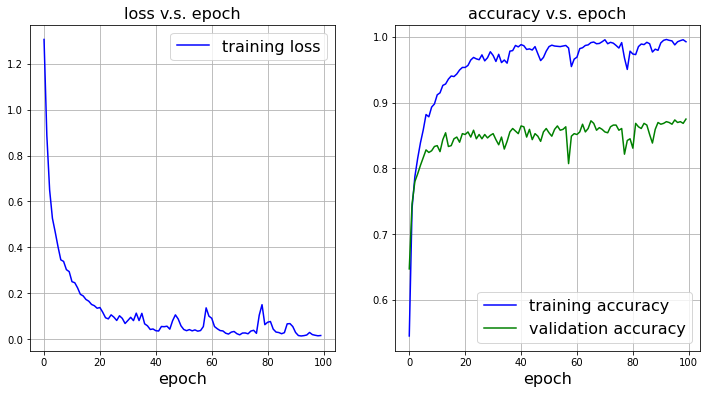

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].set_title('loss v.s. epoch',fontsize=16)
ax[0].plot(loss_train_list, '-b', label='training loss')
ax[0].set_xlabel('epoch',fontsize=16)
ax[0].legend(fontsize=16)
ax[0].grid(True)
ax[1].set_title('accuracy v.s. epoch',fontsize=16)
ax[1].plot(acc_train_list, '-b', label='training accuracy')
ax[1].plot(acc_val_list, '-g', label='validation accuracy')
ax[1].set_xlabel('epoch',fontsize=16)
ax[1].legend(fontsize=16)
ax[1].grid(True)


In [40]:
best_epoch=np.argmax(acc_val_list)
best_epoch

99

In [41]:
# testing acc

model.eval()
running_corrects = 0

for inputs, labels in loader_test:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

    running_corrects += torch.sum(preds == labels.data)

test_acc = running_corrects.double() / len(loader_test.dataset)
print(f'Test Acc: {test_acc:.4f}')


Test Acc: 0.8739
